## Chapter 7

* 일련의 예측기로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있음.
* 일련의 예측기를 앙상블(ensemble)이라 하고, 위와 같은 방식의 학습을 앙상블 학습, 이러한 알고리즘을 앙상블 방법이라고 함.
  * ex) 훈련 세트에서 여러 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킨 뒤, 가장 많은 선택을 받은 클래스를 예측으로 삼음.
* 결정 트리의 앙상블을 랜덤 포레스트(random forest)라고 함.

### 투표 기반 분류기

* 정확도가 80%인 여러 분류기를 훈련시켰다고 가정. 더 좋은 분류기를 만들기 위해 각 분류기의 에측을 모아 가장 많이 선택된 클래스를 예측함. 이렇게 다수결로 정해지는 분류기를 직접 투표(hard voting) 분류기라고 함.
* 이러한 방법이 개별 분류기 중 가장 성능이 좋은 것보다 정확도가 높을 경우가 많음.
  * 각 분류기가 약한 학습기(정확도가 낮은 분류기)더라도 분류기가 충분히 많고 다양하다면 강한 학습기(정확도가 높은 학습기)가 될 수 있음.

* 만약, 앞면이 나올 확률이 51%, 뒷면이 49%인 동전을 1000번 던지면, 앞면이 다수가 될 확률은 75%에 가까워짐.

In [3]:
from scipy.stats import binom

1-binom.cdf(499, 1000, 0.51)

0.7467502275561786

In [4]:
# 동전을 10000번 던졌을 때 앞면이 절반 이상 나올 확률
1-binom.cdf(4999, 10000, 0.51)

0.9777976478701533

* 위처럼 51% 정확도를 가진 1000개의 분류기로 앙상블 모델을 구축하여 가장 많은 클래스를 예측으로 삼는다면 75%의 정확도를 기대할 수 있음.
  * 단, 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 함.
  * 같은 데이터로 훈련시키기 때문에 분류기들이 같은 종류의 오차를 만들기 쉽고, 앙상블의 정확도가 낮아짐.
  * 보통 각기 다른 알고리즘으로 학습시켜 다른 종류의 오차를 만들 가능성을 높이면 앙상블 모델의 정확도가 올라감.

In [5]:
# Moons dataset으로 투표 기반 분류기(VotingClassifier) 생성
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

moons_data_X, moons_data_y = make_moons(n_samples=1000, noise=0.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(moons_data_X, moons_data_y, test_size=0.2, random_state=42)

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [6]:
# 각 분류기의 정확도 출력
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.82
RandomForestClassifier 0.84
SVC 0.855
VotingClassifier 0.86


> * 투표 기반 분류기의 정확도가 제일 높음.

* 투표 기반 분류기의 모든 분류기가 클래스의 확률을 예측할 수 있으면(<code>predict_proba()</code>를 쓸 수 있으면) 개별 분류기의 예측을 평균을 내어 확률이 가장 높은 클래스를 예측할 수 있고, 이를 간접 투표(soft voting)라고 함.
  * 일반적으로 직접 투표 방식보다 성능이 높음.
  * <code>voting='soft'</code>

In [7]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)        # SVC에서 클래스 확률 추정을 위해서는 probability=True가 필요.

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.82
RandomForestClassifier 0.84
SVC 0.855
VotingClassifier 0.865


### Bagging, Pasting

* 다양한 분류기를 만들기 위해서는 각기 다른 훈련 알고리믖을 사용하거나, 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시킬 수 있음.
* 훈련 세트에서 중복을 허용하여 샘플링하는 방식을 배깅(bagging, bootstrap aggregating), 중복을 허용하지 않으면 페이스팅(pasting)이라고 함.
* 배깅과 페이스팅 모두 같은 훈련 샘플을 여러 예측기에 걸쳐 사용할 수 있음.
  * 배깅만 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있음.
* 모든 예측기의 훈련이 끝나면 각 예측을 모아 새로운 샘플에 대한 예측을 만듦. 수집 함수는 분류일 때는 통계적 최빈값(가장 많은 예측 결과), 회귀에 대해서는 평균을 계산
  * 각 예측기는 원본 훈련 세트로 훈련한 것 보다 훨씬 편향되어있지만 수집 함수를 통과하면 편향과 분산이 모두 감소.
* CPU 코어나 서버에서 병렬로 학습 및 예측이 가능.

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 결정 트리 분류기 500개(n_estimators)의 앙상블을 훈련
# max_samples는 원본 데이터셋에서 샘플링할 데이터 개수
# bootstrap=False로 지정 시 페이스팅 사용
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [9]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

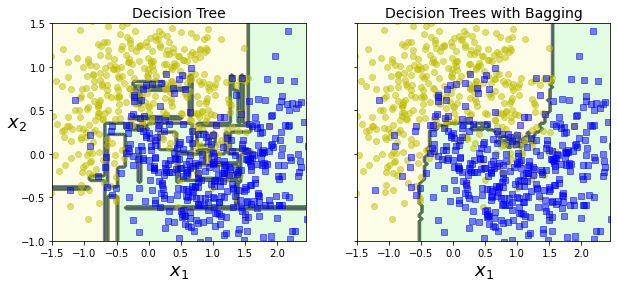

In [10]:
import numpy as np

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

> 앙상블이 비슷한 편향에서 더 적은 분산을 만듦.

* 배깅(부트스트래핑) 사용 시 서브셋의 다양성을 증가시키므로 페이스팅보다 편향이 더 높음.
* 다양성을 추가하면 예측기들의 상간관계를 줄이므로 분산을 감소시킴
* 일반적으로 배깅이 더 선호됨.

* 배깅은 일부 샘플은 한 예측기를 위해 여러 번 샘플링되고(중복을 허용하므로), 어떤 것은 전혀 선택되지 않을 수 있음
* BaggingClassifier는 중복을 허용하여 훈련 세트의 크기만큼인 m개의 샘플은 선택하므로 각 예측기에 훈련 샘플의 63%정도만 샘플링됨.
  * m개의 샘플에서 무작위로 하나를 추출할 때 선택되지 않을 확률은 $ 1-\frac{1}{m} $이고, 이를 m번 반복해도 선택되지 않을 확률은 $ \left(1-\frac{1}{m}\right)^m $이 됨. 여기에 로그를 취한 뒤 로핖탈의 정리를 적용하면 샘플링될 확률은 $ 1-e^{-1}\approx0.63212 $가 됨
* 여기서 선택되지 않은 나머지 37%를 oob(out of bag) sample이라고 함.
* 예측기의 훈련에는 oob 샘플이 사용되지 않으므로 따로 검증 세트를 만들지 않고 oob 샘플을 사용해 평가 가능.
* 앙상블의 평가는 각 예측기의 oob평가를 평균하여 얻음.
  * <code>oob_score=True</code> 시, 자동으로 oob평가를 수행

In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=2, oob_score=True
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=2, oob_score=True)

In [12]:
bag_clf.oob_score_

0.84625

In [13]:
# Test set을 이용한 정확도와 비교
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.835

In [14]:
# oob 샘플에 대한 결정 함수의 값
# 두 번째 훈련 샘플에 대해서 양성에 속할 확률은 8%, 음성에 속할 확률은 91%
bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [0.93908629, 0.06091371],
       [1.        , 0.        ],
       ...,
       [1.        , 0.        ],
       [0.66666667, 0.33333333],
       [0.        , 1.        ]])

### 랜덤 패치, 랜덤 서브스페이스

* BaggingClassifier는 특성 샘플링도 지원.
* <code>max_features, bootstrap_features</code> 매개변수로 조절
* 샘플이 아닌 특성에 대한 샘플링, 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련됨.
* 이미지와 같은 고차원의 데이터셋을 다룰 때 유용
* 특성과 샘플을 모두 샘플링하는 것을 랜덤 패치(random patches method) 방식, 훈련 샘플을 모두 사용하고 특성은 샘플링하는 방식을 랜덤 서브스페이스 방식(random subspaces method, <code>bootstrap=False, max_samples-1.0, bootstrap_features=True, max_features<1.0</code>) 이라고 함.
* 특성 샘플링 시 더 다양한 예측기를 만들며 편향을 늘리고 분산을 낮춤.

<p>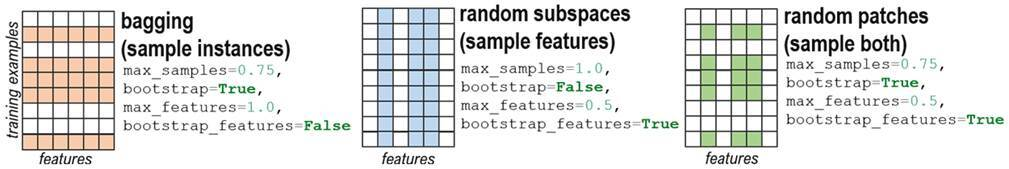</p>

> from https://livebook.manning.com/concept/machine-learning/random-patch

### Random Forest

* 배깅을 적용한 결정 트리의 앙상블
* max_samples를 훈련 세트의 크기로 지정함.
* <code>RandomForestClassifier</code>로 사용 가능.
  * 일부 예외를 제외하고 Decision Tree Classifier의 매개변수와 Bagging Classifier의 매개변수를 모두 가지고 있음
  * 예외 : <code>splitter="best", presort=False, max_samples=1.0, base_estimator=지정된 매개변수를 사용한 DecisionTreeClassifier</code>

In [15]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=2)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

* 트리의 노드 분할 시 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중 최적의 특성을 찾는 식으로 무작위성을 주입.
  * 트리가 다양해지며 편향을 손해보지만 분산을 낮춤.

In [ ]:
# BaggingClassifier를 이용해 RandomForestClassifier와 유사하게 만든 것
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16, n_estimators=500)
)

* 랜덤 포레스트에서 트리를 만들 때 무작위로 특성의 서브셋을 만들어 분할에 사용하고, 극단적으로 무작위한 트리의 랜덤 포레스트를 익스트림 랜덤 트리(extremely randomized trees, 또는 extra-trees)라고 함.
  * 편향이 늘어나고 분산을 낮춤.
  * 모든 노드에서 특성마다 가장 최적의 임계값을 찾는 것이 많은 시간이 소요되므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠름.
  * <code>ExtraTreesClassifier</code> 사용
  * RandomForestclassifier와 ExtraTreesClassifer는 어떤 것이 더 좋을 지 알 수 없으므로 둘 다 사용하는것이 좋음.

* 랜덤 포레스트는 특성의 상대적 중요도를 측정하기 쉬움.
* scikit-learn에서 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도 측정.
* 훈련이 끝난 뒤 특성마다 이 점수를 계산하고, 중요도의 전체 합이 1이 되도록 결과값을 정규화함.
  * <code>feature_importancs_</code>변수에 저장됨.
* 랜덤 포레스트는 특성을 선택할 때 어떤 특성이 중요한지 빠르게 확인할 수 있음.

In [16]:
# Iris dataset으로 특성의 중요도 출력
# 꽃잎의 길이(45%), 너비(41%)가 중요한 특성
from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10617595891813289
sepal width (cm) 0.024769450920525838
petal length (cm) 0.4503695507521931
petal width (cm) 0.4186850394091481


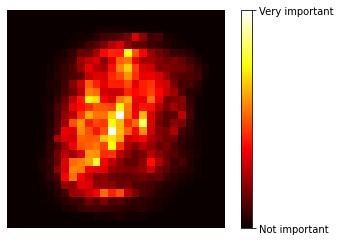

In [17]:
# mnist 데이터셋의 각 픽셀에 대한 중요도를 그래프로 출력

import matplotlib as mpl
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

### Boosting

* 부스팅(boosting, 또는 hypothesis boosting) : 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 기법
  * 앞의 모델을 보완해나가면서 일련의 예측기를 학습시킴
  * Adaboost, Gradient Boost로 나뉨